In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def run_dl():
    exit = False
    used_car_data = pd.read_csv('/Users/sumanth/Documents/TF-Udemy/DataSets/second_hand_cars.csv')
    no_of_features = used_car_data.iloc[:,1:-1].shape[-1]
    
    while(exit==False):
        print('Welcome. The data has been read!')
        print(f'Number of samples = {len(used_car_data)}')
        print(f'Number of features = {no_of_features}')
        for i in used_car_data.iloc[:,1:-1].columns.values:
            print(i.capitalize())
        
        #initializing tensor data set
        tensor_dataset = tf.data.Dataset.from_tensor_slices((used_car_data.iloc[:,1:-1],used_car_data.iloc[:,-1]))
        
        # defining function for splitting dataset
        def train_cv_test_split(data,train_ratio,cv_ratio):
            if train_ratio<1 and cv_ratio<1 and train_ratio+cv_ratio<1:
                train , intermediate = tf.keras.utils.split_dataset(dataset=data,
                                                                left_size=train_ratio,shuffle=True,seed=42)
                cv , test = tf.keras.utils.split_dataset(dataset=intermediate,
                                                         left_size=int(cv_ratio*tensor_dataset.cardinality().numpy()))
                return train, cv, test
            else:
                return "Ratio not appropriate"
            
        
        # until ratio matches the requirements
        repeat = True
        while (repeat):
            try :
                train_ratio = float(input('Enter the training set ratio : '))
                cv_ratio = float(input('Enter the cross-validation set ratio : '))
                
                train_set, cv_set, test_set = train_cv_test_split(tensor_dataset,train_ratio,cv_ratio)
                
                print(f'Samples in \nTrain set : {train_set.cardinality().numpy()}')
                print(f'CV set : {cv_set.cardinality().numpy()}')
                print(f'Test set : {test_set.cardinality().numpy()}')
                repeat = False
            except ValueError:
                print(train_cv_test_split(True,True, True))
                repeat = True
        
        # defining normalization
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(train_set.map(lambda x,y : x))
        
        def apply_normalization(x,y):
            return tf.squeeze(normalizer(x)),y 
        
        train_set = train_set.map(apply_normalization)
        cv_set = cv_set.map(apply_normalization)
        test_set = test_set.map(apply_normalization)
        
        batchsize = 0
        while batchsize not in [32,64]:
            batchsize = int(input('Enter the batch size (32/64): '))
            if batchsize not in [32,64]:
                print('Invalid!')
        
        train_pipeline = train_set.batch(batchsize).cache().prefetch(tf.data.AUTOTUNE)
        cv_pipeline = cv_set.batch(batchsize).cache().prefetch(tf.data.AUTOTUNE)
        test_pipeline = test_set.batch(batchsize).cache().prefetch(tf.data.AUTOTUNE)
        
        # initialize NN architectural details
        no_of_layers = int(input('Enter the number of hidden layers in the Neural Network : '))
        no_of_neurons = []
        type_activation = []
        for i in range(no_of_layers):
            no_of_neurons.append(int(input(f'Enter the number of neurons in hidden layer {i+1} : ')))
            act = ''
            while act not in ['l','r']:
                act = input(f'Enter the activation type for layer {i+1} Linear(l)/Relu(r) : ')
                if act not in ['l','r']:
                    print('Invalid!')
                elif act == 'r':
                    type_activation.append('relu')
                else:
                    type_activation.append('linear')
            
        neural_network = tf.keras.models.Sequential(name='NeuralNetwork_Dense')
        neural_network.add(tf.keras.layers.InputLayer(shape=(no_of_features,)))
        
        for i,n in enumerate(range(no_of_layers)):
            neural_network.add(tf.keras.layers.Dense(units=no_of_neurons[i],
                                                     activation=type_activation[i],name='Layer_'+str(i+1)))    
        #output layer
        neural_network.add(tf.keras.layers.Dense(units=1,activation='linear',name='Output_Layer'))
        
        neural_network.summary()
        
        # getting optimiser, loss and metric details
        opt = ''
        los = ''
        met = ''
        
        while opt not in ['s','a']:
            opt = input('Enter the optimizer type SGD(s) / Adam(a) : ')
            if opt not in ['s','a']:
                print('Invalid!')
            elif opt == 'a':
                learn_rate = float(input('Enter the learning rate : '))
                optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
            else : 
                optimizer = tf.keras.optimizers.SGD()
                
        while los not in ['m','h']:
            los = input('Enter the loss type Mean Squared Error(m) / Huber(h) : ')
            if los not in ['m','h']:
                print('Invalid!')
            elif los == 'm':
                loss = tf.keras.losses.MSE
            else :
                loss = tf.keras.losses.Huber
                
        while met not in ['m','r']:
                met = input('Enter the optimizer type Mean Absolute Error(m)/Root Mean Squared Error(r) : ')
                if met not in ['m','r']:
                    print('Invalid!')
                elif met == 'm':
                    metric = tf.keras.metrics.MAE
                else : 
                    metric = tf.keras.metrics.RootMeanSquaredError
        
        neural_network.compile(optimizer=optimizer,loss=loss,metrics=[metric])                   
        
        rounds = 1000
        while rounds >= 100:
            rounds = int(input('Enter the number of epoch(s) (<=100): '))
            if rounds>100:
                print('Invalid')
        
        model_history = neural_network.fit(train_pipeline,validation_data=cv_pipeline,epochs=rounds)
        
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.legend(['Train','CV'])
        plt.title('Training loss Vs Validation Loss')
        plt.xlabel('epoch(s)')
        plt.ylabel('Loss')
        plt.show()
        
        print('Loss and Metric on Cross Validation set')
        for metric,value in zip(neural_network.metrics_names,neural_network.evaluate(cv_pipeline)):
            print(metric,' : ',value)
            
        y_test_predicted = neural_network.predict(test_pipeline)
        
        y_test_actual = [y for x,y in test_pipeline]
        y_test_actual = tf.concat(values=[x for x in y_test_actual],axis=0)
        
        plt.figure(figsize=(20,12))
        plt.plot(y_test_predicted)
        plt.plot(y_test_actual)
        plt.legend(['Predicted','Actual'])
        plt.title('Actual price Vs Predicted Price on test set')
        plt.xlabel('Samples')
        plt.ylabel('Price')
        plt.show()
        
        flag = ''
        while flag not in ['y','e']:
            flag = input('Do want to try another round (y) / exit (e) : ')
            if flag not in ['y','e']:
                print('Invalid')
            if flag == 'y':
                exit = False
            else:
                exit = True
        

Welcome. The data has been read!
Number of samples = 1000
Number of features = 10
On road old
On road now
Years
Km
Rating
Condition
Economy
Top speed
Hp
Torque


2025-07-26 23:10:50.424023: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-07-26 23:10:50.424044: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-26 23:10:50.424049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-26 23:10:50.424064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-26 23:10:50.424074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Enter the training set ratio : 0.7
Enter the cross-validation set ratio : 0.15
Samples in 
Train set : 700
CV set : 150
Test set : 150


2025-07-26 23:10:59.397271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-26 23:10:59.423615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-26 23:10:59.542366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Enter the batch size (32/64): 32
Enter the number of hidden layers in the Neural Network : 3
Enter the number of neurons in hidden layer 1 : 25
Enter the activation type for layer 1 Linear(l)/Relu(r) : r
Enter the number of neurons in hidden layer 2 : 50
Enter the activation type for layer 2 Linear(l)/Relu(r) : r
Enter the number of neurons in hidden layer 3 : 30
Enter the activation type for layer 3 Linear(l)/Relu(r) : r


Model: "NeuralNetwork_Dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer_1 (Dense)                 │ (None, 25)             │           275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_2 (Dense)                 │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_3 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,136 (12.25 KB)

 Trainable params: 3,136 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Enter the optimizer type SGD(s) / Adam(a) : a
Enter the learning rate : 0.01
Enter the loss type Mean Squared Error(m) / Huber(h) : m
Enter the optimizer type Mean Absolute Error(m)/Root Mean Squared Error(r) : r
Enter the number of epoch(s) (<=100): 15
Epoch 1/15


2025-07-26 23:11:30.963863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 109877379072.0000 - root_mean_squared_error: 331433.4062 - val_loss: 109283958784.0000 - val_root_mean_squared_error: 330581.2500
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 109817528320.0000 - root_mean_squared_error: 331343.5625 - val_loss: 108926287872.0000 - val_root_mean_squared_error: 330039.8125
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109049126912.0000 - root_mean_squared_error: 330186.2812 - val_loss: 106087161856.0000 - val_root_mean_squared_error: 325710.2500
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 104383930368.0000 - root_mean_squared_error: 323058.1562 - val_loss: 94818107392.0000 - val_root_mean_squared_error: 307925.5000
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 89006514176.0000 - root_mean_squared_error: 298313.8750 - val_loss: 68857905152.0000 - val_root_mean_squared_error: 262407.9062
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 60156428288.000

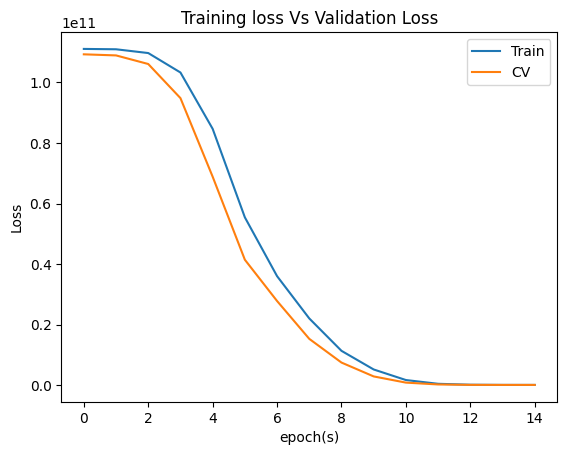

Loss and Metric on Cross Validation set
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79176864.0000 - root_mean_squared_error: 8896.0537
loss  :  79032384.0
compile_metrics  :  8890.015625
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-07-26 23:11:34.234020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


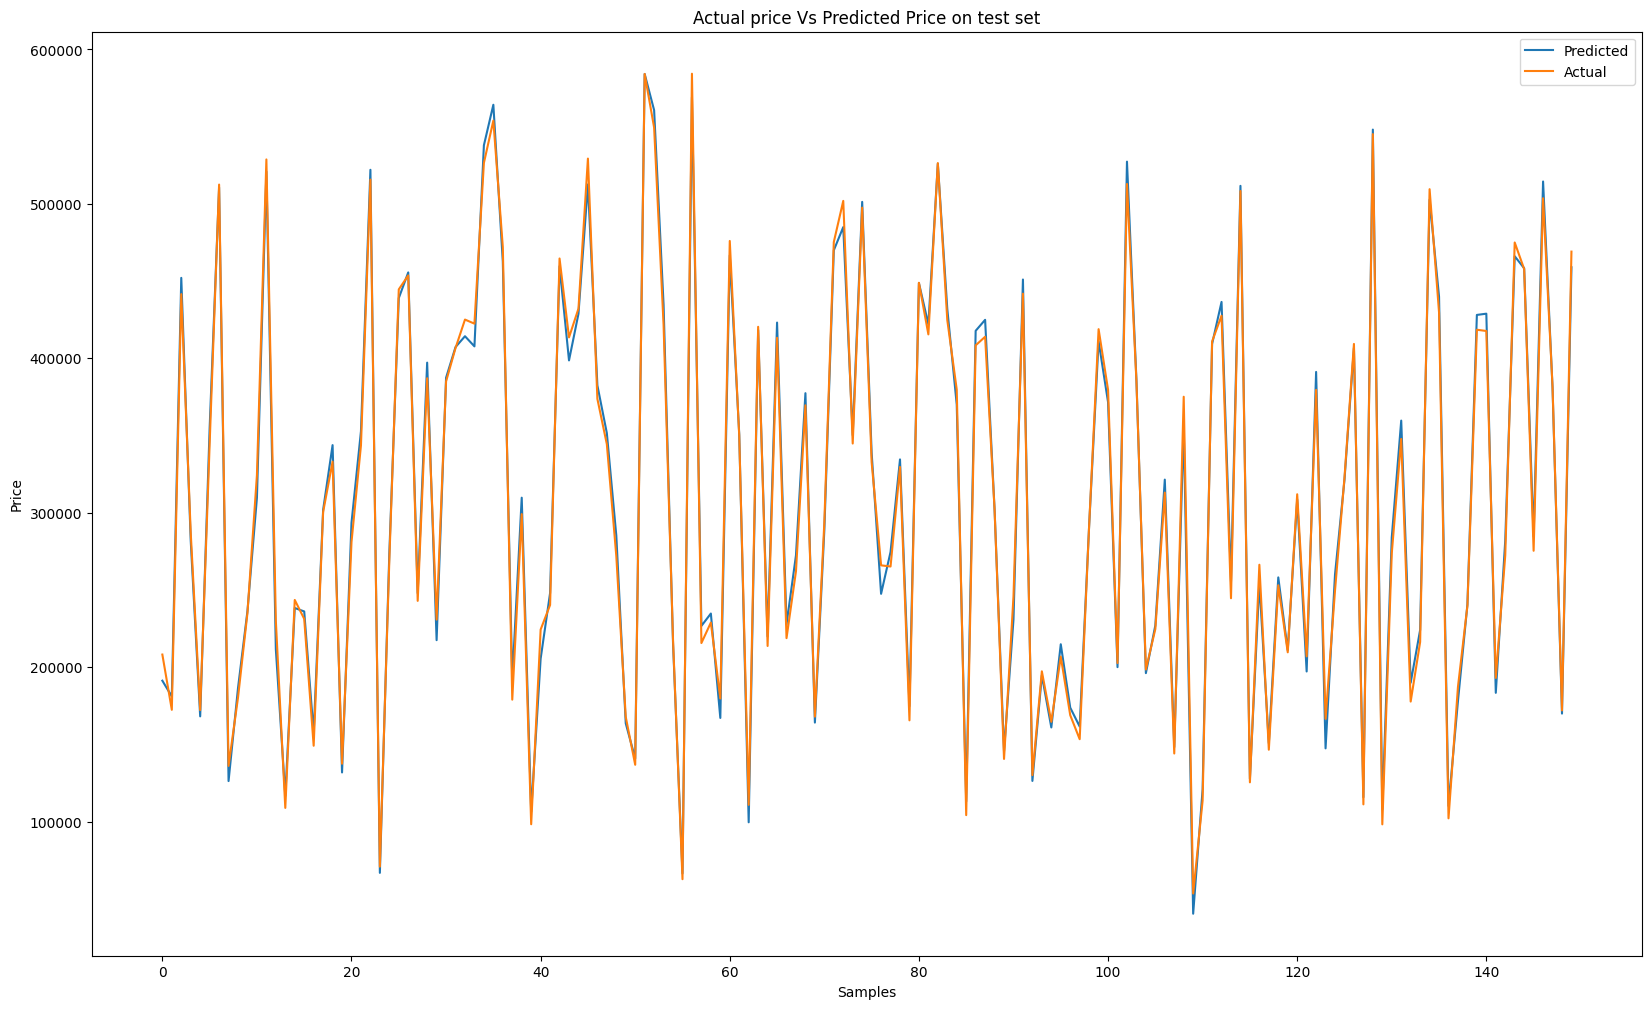

Do want to try another round (y) / exit (e) : e


In [3]:
run_dl()